In [1]:
using Plots
using Polynomials
include("./includes/matprops.jl");

# Material- Stoffdaten

In diesem Notebook behandeln wir einige Grundlagen zur Umgangsweise mit Stoff- bzw. Materialdaten. Stoffdaten sind eine grundlegende Voraussetzung (fast) jeder physikalischen Berechnung. Leider sind diese nicht immer unbedingt einfach und hundertprozentig exakt zu bestimmen. 
Folgende Aussagen können beispielsweise in Bezug zu Materialdaten getroffen werden, diese sollte man generell bei der Modellierung (thermischen Verhaltens) im Hinterkopf behalten:

 - Materialdaten sind Vereinfachungen zur Vorhersage bestimmter Eigenschaften oder Verhaltensweisen von Materialien und sind eine Grundlage für die Modellierung des Verhaltens von Materie
 - Im Bezug auf thermische (CFD) Modellierungen spricht man im allgemeinen  häufig von thermophysikalischen Materialdaten
 - Materialeigenschaften sind in der Regel temperaturabhängig
 - Materialeigenschaften von Gasen und Flüssigkeiten sind in der Regel zudem auch druckabhängig
 - Materialdaten vor allem von Festkörpern sind oft nicht isotrop
 - Materialeigenschaften hängen bei vielen Feststoffen beispielsweise Metallen nicht nur von der chemischen Zusammensetzung, sondern auch von der Vorverarbeitung des Metalls ab
 - Materialdaten enthalten häufig eine gewisse Vereinfachung des auf mikroskopischer Ebene komplizierten Verhaltens von 
 - Eine exakte Materialdatenbestimmung mit sehr hoher Genauigkeit ist für viele Eigenschaften nicht trivial - daher können Materialdaten aus verschiedenen Quellen abweichen
 
Hier beschäftigen wir uns aber nicht mit den Problemen oder den Grundlagen der Stoffdatenbestimmung, das sind oder waren Themen in anderen Lehrveranstaltungen ihres Studiums, sondern verwenden vorgefertigt einige Stoffdaten aus dem Incropera [T. L. Bergman and A. S. Lavine, Fundamentals of heat and mass transfer. 2017.
] und nehmen auch an, dass diese korrekt sind (Fehleranalyse bzw. Sensitivitätsanalyse ist auch nicht Teil dieser Veranstaltung). Die Stoffdaten liegen als CSV (Comma-Seperated-Value Format) im Unterordner `matdata`.

Fangen wir an in dem wir als erstes die Stoffdaten für die Wärmeleitfähigkeit von Luft, mit einer vorgefertigten Funktion, einlesen:

In [2]:
λ_air = matprops.read_properties("./matdata/AIR.csv" , "lambda")

("W/(m*K)", 1000.0, [100.0, 150.0, 200.0, 250.0, 300.0, 350.0, 400.0, 450.0, 500.0, 550.0  …  1700.0, 1800.0, 1900.0, 2000.0, 2100.0, 2200.0, 2300.0, 2400.0, 2500.0, 3000.0], [9.34, 13.8, 18.1, 22.3, 26.3, 30.0, 33.8, 37.3, 40.7, 43.9  …  113.0, 120.0, 128.0, 137.0, 147.0, 160.0, 175.0, 196.0, 222.0, 486.0])

Der Rückgabewert dieser Funktion ist ein [Tupel](https://de.wikipedia.org/wiki/Tupel_(Informatik)) aus: (Einheit, Einheitsmultiplikator, Temperaturwert(e), Materialeigenschaftswert(e))

> **Einheitsmultiplikator?** <br/>
> Soweit so gut, aber was ist der hier als _Einheitsmultiplikator_ bezeichnete Wert? Häufig sind thermophysikalische Daten in SI Einheiten gegeben, da sich aber nicht alle Zahlen in einem "schönen" Wertebereich befinden, werden diese mit einem Faktor multipliziert der häufig im Tabellenkopf vor (oder hinter) die Einheit geschrieben wird, um den Wert einer Eigenschaft in der angegebenen SI-Einheit zu erhalten, muss also ggf. wieder durch diesen geteilt werden

Stellen wir diese Daten (mit Berücksichtung des Einheitsmultiplikators) der Wärmeleitfähigkeit von Luft einnmal dar:

In [31]:
plot(λ_air[3],λ_air[4]/λ_air[2], linealpha = 0, markersize = 4,
    marker =:circle, label="", legend = :topleft,
    xlabel = "Temperatur in K", ylabel = "Wärmeleitfähigkeit in W(m K)",
    framestyle = :box, dpi = 120)

## Physikalische Gleichungen

Es gibt einige Stoffdaten, die sich recht gut über physikalische Gleichungen modellieren lassen. Darunter zum Beispiel die Dichte trockener Luft bei Normaldruck mit dem idealen Gasgesetz.

$$p \cdot V = n \cdot R \cdot T$$

mit $n = m/M$ ergibt sich:

$$\rho = \frac{m}{V} = \frac{p \cdot M}{R \cdot T} = \frac{p \cdot M}{R} \cdot \frac{1}{T} $$

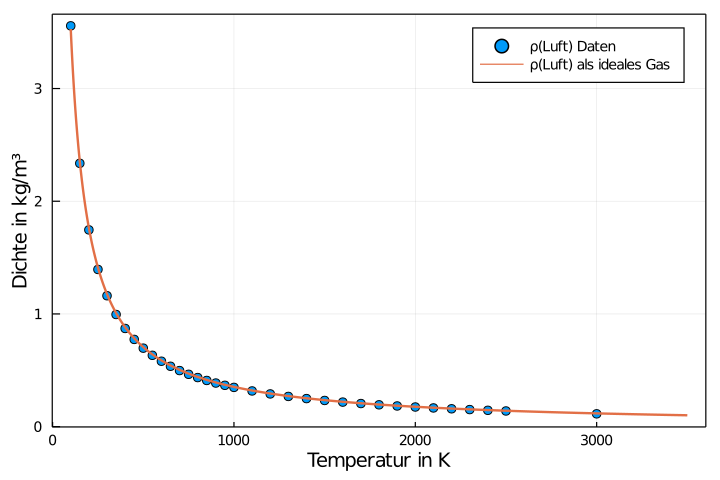

In [30]:
p = 101325
T = collect(100.0:1:3500.0);
R = 8.31446261815324
M_luft = 28.949*1E-3
ρ_ideal_air(T) = (p*M_luft)/R  * 1 ./T

ρ_air = matprops.read_properties("./matdata/AIR.csv" , "rho")
plot(ρ_air[3],ρ_air[4]/ρ_air[2], 
    linealpha = 0, markersize = 4, marker =:circle, 
    label="ρ(Luft) Daten", xlabel = "Temperatur in K", ylabel = "Dichte in kg/m³",
    framestyle = :box, dpi = 120)
plot!(T,ρ_ideal_air(T), label = "ρ(Luft) als ideales Gas", linewidth = 2)

Die Übereinstimmung ist wie oben zu sehen sehr gut.
Leider gibt es nicht für alle Stoffe und Materialeigenschaften und für alle Bereiche ausreichend genaue Näherungsgleichungen. 
Daher werden vor allem Zwischenwerte oft aus Messdaten interpoliert.

---
# Interpolation von Material- Stoffdaten

Wie wir in obigen Beispielen sehen, geben uns Messdaten Werte für Materialdaten an bestimmten diskreten Stellen. Diese können mittels verschiedener Interpolationsmethoden auf einen kontinuierlichen Wertebereich übertragen werden. Natürlich je nach verwendeter Methode mit gewissen Vor- und Nachteilen.

## Lineare Interpolation
Das einfachste und ein häufig verwendetes Verfahren ist die lineare Interpolation, welches sich auch am einfachsten auf mehrere Dimensionen übertragen lässt z. B. für druck- und temperaturabhängigen Stoffdaten. Wir bleiben im Folgenden bei der eindimensionalen Interpolation einer abhängigen Größe.

Lineares Verhalten wird im natürlichen Verhalten von Materialien üblicherweise selten beobachtet, dennoch kann es bei ausreichend vielen Messdaten lokal eine gute Näherung darstellen, vor allem wenn keine Extrapolation der Daten erfolgen muss.

Für die Extrapolation von Messdaten kann eine lineare Extrapolation oder eine Begrenzung auf den letzten Wert erfolgen. Beide Methoden sind mit Bedacht zu wählen, ggf. sollte auf physikalische Regression, siehe unten, zurückgegriffen werden, wenn viele Werte auf einen nicht in den Messdaten vorhandenen Bereich extrapoliert werden müssen.

Beide Varianten (lineare Interpolation mit linearer Extrapolation oder Begrenzung) sind im Folgenden beispielhaft dargestellt:

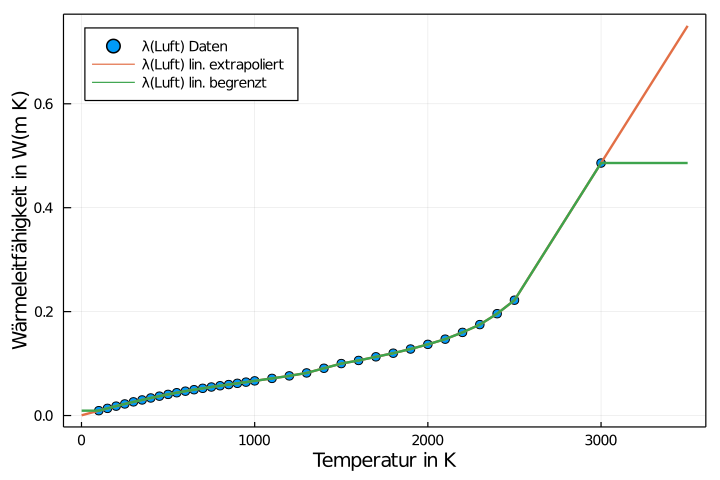

In [33]:
T = collect(1.0:1:3500.0);

λ_air = matprops.read_properties("./matdata/AIR.csv", "lambda")

λ_air_interp = matprops.interp_property(λ_air,T);

λ_air_interp_bounded = matprops.interp_property_bounded(λ_air,T);

plot(λ_air[3],λ_air[4]/λ_air[2], linealpha = 0, markersize = 4, marker =:circle,  
    label="λ(Luft) Daten", legend = :topleft,
    xlabel = "Temperatur in K", ylabel = "Wärmeleitfähigkeit in W(m K)",
    framestyle = :box, dpi = 120);
plot!(T, λ_air_interp/λ_air[2], label = "λ(Luft) lin. extrapoliert", linewidth = 2);
plot!(T, λ_air_interp_bounded/λ_air[2], label = "λ(Luft) lin. begrenzt", linewidth = 2)

## Regression

Über Regressionsmethoden z.B die Methode der kleinsten (Fehler)-Quadrate (siehe auch: https://de.wikipedia.org/wiki/Methode_der_kleinsten_Quadrate) können Minimierungsprobleme mit beliebigen Fit-Funktionen formuliert werden. Hierbei gibt es verschiedene Funktionen und Funktionsreihen (z.B. Ausgleichgerade und Ausgleichpolynome), deren Minimierungsparameter sich durch das Lösen eines linearen Gleichungssystem bestimmen lassen. Weiterhin können beliebige Funktionen, über die Formulierung eines Miniums-Problem mit der Methode der kleinsten Quadrate, mit Hilfe von Optimierungsalgorythmen wie dem hierfür häufig verwendeten Levenberg-Marquardt-Algorithmus (siehe auch: https://de.wikipedia.org/wiki/Levenberg-Marquardt-Algorithmus) auf eine Datenreihe angepasst werden. Für gute Ergebnisse sind hier allerdings gewisse Voraussetzungen an die Menge der Daten und den Aufbau der Fit-Funktion zu stellen.


Im folgenden Beispiel verwendet wir die Fitfunktion:

$$ m(T) = a \cdot \frac{1}{T^2}$$

und passen den Parameter $a$ mit Hilfe der oben genannten Methoden (die im Packet LsqFit.jl https://github.com/JuliaNLSolvers/LsqFit.jl implementiert sind) an die Datenreihe `ρ_air` an.

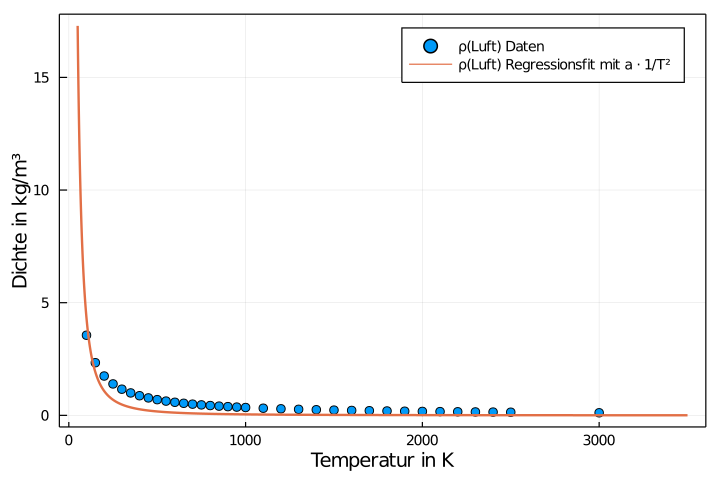

In [35]:
using LsqFit

m(t, p) = p[1] * 1 ./t.^2
p0 = [0.5]
myfit = curve_fit(m, ρ_air[3], ρ_air[4]/ρ_air[2], p0)


T = collect(50.0:1:3500.0);
plot(ρ_air[3],ρ_air[4]/ρ_air[2], linealpha = 0, markersize = 4, marker =:circle, 
        label="ρ(Luft) Daten", xlabel = "Temperatur in K", ylabel = "Dichte in kg/m³",
        framestyle = :box, dpi = 120);
plot!(T, m(T, myfit.param), label = "ρ(Luft) Regressionsfit mit a ⋅ 1/T²", linewidth = 2)

Wie zu erwarten lässt sich durch die verwendete Gleichung allerdings keine perfekte Übereinstimmung herstellen.

### Polynom-Regression
Häufig werden auch Polynom-Regression verwendet, da diese in Excel verfügbar sind und oft einen kleinen Regressionsfehler $R^2$ erzielen. Wie wir zeigen werden ist dies deswegen aber nicht immer die beste Wahl. Wir verwenden hierfür das Package "Polynomials", welches die Daten mittels Polynom-Regression (https://en.wikipedia.org/wiki/Polynomial_regression) "fittet".

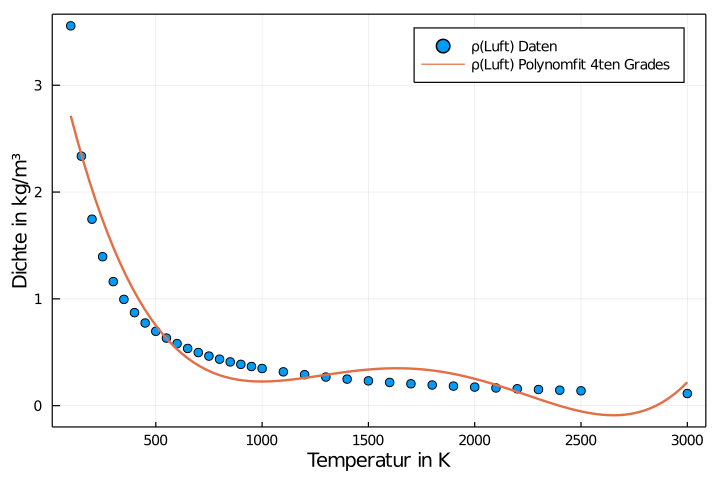

In [36]:
poly_deg = 4
myfit = fit(ρ_air[3], ρ_air[4]/ρ_air[2], poly_deg)

plot(ρ_air[3],ρ_air[4]/ρ_air[2], linealpha = 0, markersize = 4, marker =:circle, 
        label="ρ(Luft) Daten", xlabel = "Temperatur in K", ylabel = "Dichte in kg/m³",
        framestyle = :box, dpi = 120);
plot!(myfit, extrema(ρ_air[3])..., label="ρ(Luft) Polynomfit "*string(poly_deg)*"ten Grades",
      linewidth = 2)

Der Fit sieht hier erstmal nicht so schlecht aus. Jetzt erweitern wir den Bereich etwas wie bei den vorherigen Fit:

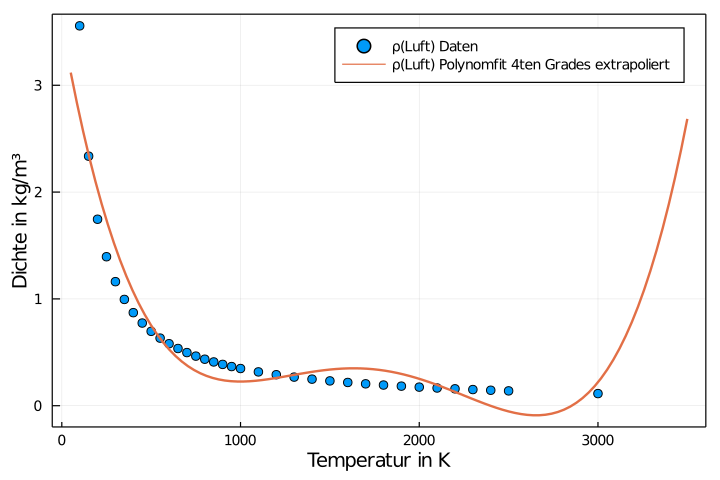

In [37]:
plot(ρ_air[3],ρ_air[4]/ρ_air[2], linealpha = 0, markersize = 4, marker =:circle, 
        label="ρ(Luft) Daten", xlabel = "Temperatur in K", ylabel = "Dichte in kg/m³",
        framestyle = :box, dpi = 120);
plot!(myfit, extrema(T)..., label="ρ(Luft) Polynomfit "*string(poly_deg)*"ten Grades extrapoliert",
      linewidth = 2)

Jetzt ist zu erkennen, dass besonders bei dem zu extrapolierenden Wertebereich ein hoher Fehler zu erwarten ist, da Polynom-Regressionen dazu neigen schnell und stark außerhalb des zum "Fitten" verwendeten Wertebereichs zu "überschwingen".

## "Physikalisch basierte Regression"

Hier kommen wir zu den Punkt "physikalisch basierter Regression", also Regressionsgleichungen die den bekannter physikalischer Verhaltensweisen stark ähneln und häufig eine gute erste Wahl sind. Dabei werden Grundgleichungen die üblicherweise den Trend von Stoffdatenverhalten widerspiegeln als Grundlage für die Regressionsgleichung verwendet. Bei Viskositäten von Flüssigkeiten kommt dabei z.B. die bekannte Vogel-Fulcher-Tammann-Gleichung (VFT-Gleichung) zu Einsatz. Wir verwenden hier als Beispiel die dem idealen Gasgesetz nahestehende Funktion:

$$ m(T) = a \cdot \frac{1}{T}$$

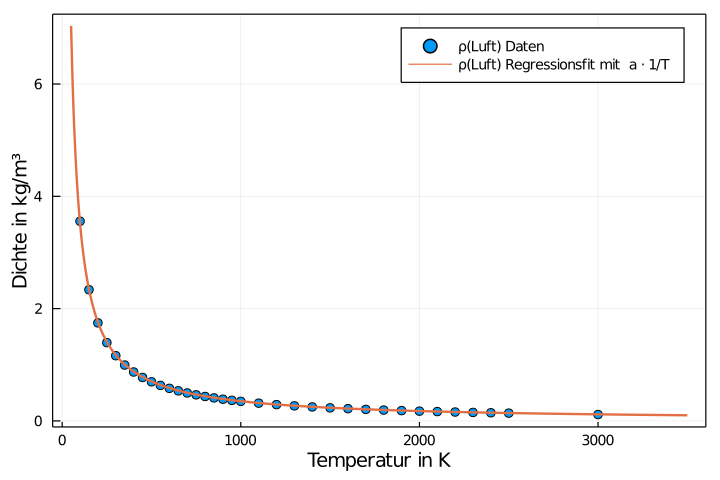

In [38]:
m(t, p) = p[1] *  1 ./t
p0 = [0.5]
myfit = curve_fit(m, ρ_air[3], ρ_air[4]/ρ_air[2], p0)

T = collect(50.0:1:3500.0);
plot(ρ_air[3],ρ_air[4]/ρ_air[2], linealpha = 0, markersize = 4, marker =:circle, 
     label="ρ(Luft) Daten", xlabel = "Temperatur in K", ylabel = "Dichte in kg/m³",
     framestyle = :box, dpi = 120);
plot!(T, m(T, myfit.param), label = "ρ(Luft) Regressionsfit mit  a ⋅ 1/T", linewidth = 2)

Wie hier zu sehen ist der Modellparameter fast identisch zu den Parametern des idealen Gasgesetzes:

$$a \approx \frac{p \, M}{R}$$

In [10]:
println("p*M_luft/R: ", (p * M_luft)/R)
println("a:\t    ", myfit.param[1])

p*M_luft/R: 352.78977845131243
a:	    351.79603756602774


Bestimmen wir die Abweichungen beider Modellevarianten von den "Messdaten":

In [11]:
err_ideal = abs.(ρ_air[4] - ρ_ideal_air.(ρ_air[3]))
println("Summierte Abweichung Ideales Gasgesetz - Messdaten: ", sum(err_ideal))

err_ideal_based = abs.(ρ_air[4] - m.(ρ_air[3], myfit.param))
println("Summierte Abweichung Regression basierend auf idealem Gasgesetz - Messdaten: ", sum(err_ideal_based))

Summierte Abweichung Ideales Gasgesetz - Messdaten: 0.242430773156472
Summierte Abweichung Regression basierend auf idealem Gasgesetz - Messdaten: 0.20153036024681198


Anhand der Abweichungen ist zu sehen, dass so physikalische basierte Gleichungen verwendet werden können, um leichte Abweichungen vom Verhalten des Materials/Stoffs vom idealistischen Modell noch genauer abzubilden, auch wenn in diesem Beispiel die Kosten des Mehraufwands sicher höher sind als der tatsächliche Erkenntnisgewinn, macht eine solche Vorgehensweise in vielen Fällen häufig Sinn. Dennoch kann es auch hier zu stärkeren Abweichungen kommen, wenn das Materialverhalten stark von der zu Grunde liegenden Modellgleichung abweicht.